<a href="https://colab.research.google.com/github/rodrigohaddad/RNSP/blob/main/experiments/wisardpkg_(solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wisardpkg

In [ ]:
import wisardpkg as wp

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# WisardPkg: Uma Implementação da família de Modelos WiSARD

## 1. Introdução

`wisardpkg` é uma biblioteca que implementa o algorimo *WiSARD* original e também múltiplos algoritmos variantes que foram propostos mais recentemente. É inteiramente implementada em C++, mas possui um wrapper em Python para uso mais conveniente. A biblioteca é hospedada no [Github](https://github.com/IAZero/wisardpkg).

## 2. Exemplo inicial



Para dar um primeiro exemplo de como podemos empregar a WiSARD, vamos pensar na tarefa de distinguir dois caracteres em imagens 3 x 3: os caracteres "T" e "H". Abaixo vemos as duas imagens que usaremos como exemplos de treino:

In [ ]:
T = [
  [1, 1, 1],
  [0, 1, 0],
  [0, 1, 0]
]

H = [
  [1, 0, 1],
  [1, 1, 1],
  [1, 0, 1]
]

def display_chars(chars):
  fig, axs = plt.subplots(1, len(chars))

  for i, char in enumerate(chars):
    img = char/np.max(char)
    axs[i].imshow(char, cmap="gray_r", vmin=0., vmax=1.)
    axs[i].axes.xaxis.set_visible(False)
    axs[i].axes.yaxis.set_visible(False)

  return fig


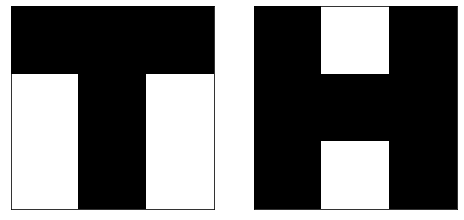

In [ ]:
display_chars([T, H]);

Agora, vamos treinar um modelo sobre esses dois caracteres:

In [ ]:
def flatten(char):
  return np.reshape(char, (-1,)).tolist()

In [ ]:
model = wp.Wisard(3)

training_set = [flatten(char) for char in [T, H]]

model.train(training_set, ["T", "H"])

Podemos testar contra os próprios exemplos de treino:

In [ ]:
model.classify(training_set)

['T', 'H']

Ser capaz de classificar corretamente imagens já vistas antes, no entanto, não é muito surpreendente. Como o modelo se sai com exemplos novos?

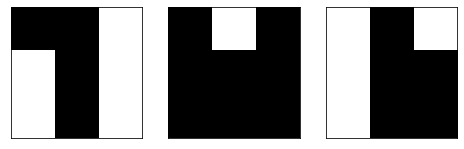

In [ ]:
new_examples = [
  [
   [1, 1, 0],
   [0, 1, 0],
   [0, 1, 0]
  ],
  [
   [1, 0, 1],
   [1, 1, 1],
   [1, 1, 1]
  ],
  [
   [0, 1, 0],
   [0, 1, 1],
   [0, 1, 1]
  ]
]

display_chars(new_examples);

In [ ]:
test_set = [flatten(char) for char in new_examples]

model.classify(test_set)

['T', 'H', 'T']

Nesse exemplo, não demos muita atenção hiperparâmetros do modelo, mas há alguns deles e o ajuste correto é extremamente para alcançar uma boa performance, especialmente em tarefas mais complexas. A lista de hiperparâmetros desse modelo e suas descrições podem ser vistas [aqui](https://iazero.github.io/wisardpkg/models/wisard).

O que exatamente o modelo aprendeu? O que reside nos neurônios RAM? Podemos ter uma ideia através das imagens mentais do modelo:

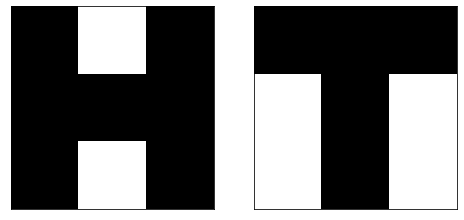

In [ ]:
def inflate(char):
  return np.reshape(char, (3, 3)).tolist()

images = model.getMentalImages()

display_chars([inflate(image) for image in images.values()]);

Nesse exemplo, as imagens mentais são exatamente os exemplos de treino, pois apresentamos apenas um exemplo por classe. No entanto, em uma tarefa mais realista, teríamos múltiplos exemplos por classe, cada um com suas particularidades. Nesses cenários, as imagens são bem mais difusas e mostram que o modelo tenta assimilar as características fundamentais das classes. Isso é bem visível nas imagens mentais de um modelo treinado sobre o MNIST.

## 3. Indo além de exemplos simples

Nesse momento, os resultados demonstrados acima podem não parecer muito impressionantes. Verdadeiramente, eles não são. Distinguir imagens compostas de meros 9 pixels não é uma tarefa difícil. No entanto, redes neurais sem peso não estão de forma alguma limitadas a problemas de tão baixas dimensões. Desde sua incepção, a WiSARD foi empregada em tarefas mais complicadas. Um exemplo de maiores dimensões, e que ainda assim não representa os limites do modelo, e a classificação de dígitos do conjunto de dados MNIST. A WiSARD é capaz de alcançar altos níveis de acurácia quando trainada e avalida com o MNIST.

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
def sample_digit(target, X=X, y=y):
    return next((digit for (digit, label) in zip(X, y) if label == str(target))).reshape((28,28))

def display_mnist_digits():
    fig, axs = plt.subplots(2, 5)
    
    for i in range(2):
        for j in range(5):
            axs[i, j].imshow(sample_digit(5*i + j), cmap="gray")
            axs[i, j].axes.xaxis.set_visible(False)
            axs[i, j].axes.yaxis.set_visible(False)
  
    return fig

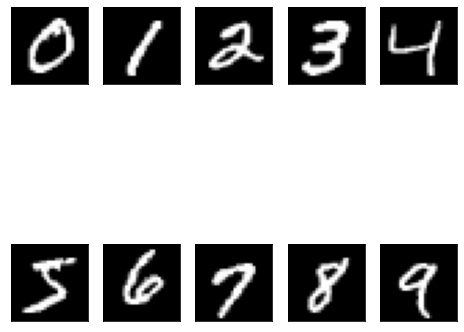

In [ ]:
display_mnist_digits();

In [ ]:
X[0].shape

(784,)

Binarizando imagens:

In [ ]:
def binarize(image, threshold):
  return np.where(image > threshold, 1, 0).tolist()


def binary_encoder(images, threshold=127):
  return [binarize(image, threshold) for image in images]

In [ ]:
X_bin = binary_encoder(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_bin, y, test_size=1/7, random_state=1)

Agora, vamos treinar um primeiro modelo WiSARD:

In [ ]:
%%time
model = wp.Wisard(3)

model.train(X_train, y_train.tolist())

CPU times: user 1.46 s, sys: 95 ms, total: 1.55 s
Wall time: 1.55 s


Vamos definir uma função para medir a acurácia:

In [ ]:
def accuracy(y_pred, y_target):
  return np.where(y_pred == y_target, 1, 0).sum()/len(y_target)

In [ ]:
%%time
accuracy(model.classify(X_test), y_test)

CPU times: user 54.9 s, sys: 193 ms, total: 55.1 s
Wall time: 54.9 s


0.7005

Variando o tamanho de tupla:

In [ ]:
%%time
model_2 = wp.Wisard(28)

model_2.train(X_train, y_train.tolist())

print(accuracy(model_2.classify(X_test), y_test))

0.9099
CPU times: user 2.83 s, sys: 68 ms, total: 2.9 s
Wall time: 2.89 s


Imagens mentais:

In [ ]:
def display_digits(images):
  fig, axs = plt.subplots(2, 5, squeeze=True)

  for i, img in enumerate(images.values()):
    img = np.reshape(img, (28, 28))
    img = img/np.max(img)
    fig.axes[i].imshow(img, cmap="gray", vmin=0., vmax=1.)
    fig.axes[i].xaxis.set_visible(False)
    fig.axes[i].yaxis.set_visible(False)

  return fig

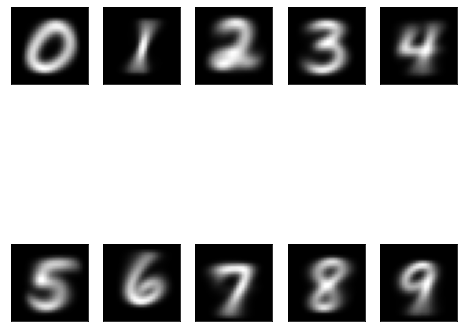

In [ ]:
display_digits(model_2.getMentalImages());